<a href="https://colab.research.google.com/github/yuichi0625/cellar/blob/main/chapters/%E7%AC%AC07%E7%AB%A0_%E5%8D%98%E8%AA%9E%E3%83%99%E3%82%AF%E3%83%88%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

単語の意味を実ベクトルで表現する単語ベクトル（単語埋め込み）に関して，以下の処理を行うプログラムを作成せよ．

# 目次
- [60. 単語ベクトルの読み込みと表示](#60.-単語ベクトルの読み込みと表示)
- [61. 単語の類似度](#61.-単語の類似度)
- [62. 類似度の高い単語10件](#62.-類似度の高い単語10件)
- [63. 加法構成性によるアナロジー](#63.-加法構成性によるアナロジー)
- [64. アナロジーデータでの実験](#64.-アナロジーデータでの実験)
- [65. アナロジータスクでの正解率](#65.-アナロジータスクでの正解率)
- [66. WordSimilarity-353での評価](#66.-WordSimilarity-353での評価)
- [67. k-meansクラスタリング](#67.-k-meansクラスタリング)
- [68. Ward法によるクラスタリング](#68.-Ward法によるクラスタリング)
- [69. t-SNEによる可視化](#69.-t-SNEによる可視化)

In [1]:
import platform
import sys
import gensim
import matplotlib
import pandas
import scipy
import tqdm

print(f'        OS: {platform.platform()}')
print('    Python: {}'.format(sys.version.replace('\n', ' ')))
print(f'Matplotlib: {matplotlib.__version__}')
print(f'     SciPy: {scipy.__version__}')
print(f'    gensim: {gensim.__version__}')
print(f'    pandas: {pandas.__version__}')
print(f'      tqdm: {tqdm.__version__}')

        OS: Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
    Python: 3.7.10 (default, Feb 20 2021, 21:17:23)  [GCC 7.5.0]
Matplotlib: 3.2.2
     SciPy: 1.4.1
    gensim: 3.6.0
    pandas: 1.1.5
      tqdm: 4.41.1


# 60. 単語ベクトルの読み込みと表示
Google Newsデータセット（約1,000億単語）での[学習済み単語ベクトル](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)（300万単語・フレーズ，300次元）をダウンロードし，”United States”の単語ベクトルを表示せよ．ただし，”United States”は内部的には”United_States”と表現されていることに注意せよ．

In [2]:
!wget "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gunzip GoogleNews-vectors-negative300.bin.gz

--2021-03-29 08:41:26--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.48.30
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.48.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  30.5MB/s    in 51s     

2021-03-29 08:42:17 (31.0 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [3]:
from gensim.models import KeyedVectors

wv = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
wv['United_States']

array([-3.61328125e-02, -4.83398438e-02,  2.35351562e-01,  1.74804688e-01,
       -1.46484375e-01, -7.42187500e-02, -1.01562500e-01, -7.71484375e-02,
        1.09375000e-01, -5.71289062e-02, -1.48437500e-01, -6.00585938e-02,
        1.74804688e-01, -7.71484375e-02,  2.58789062e-02, -7.66601562e-02,
       -3.80859375e-02,  1.35742188e-01,  3.75976562e-02, -4.19921875e-02,
       -3.56445312e-02,  5.34667969e-02,  3.68118286e-04, -1.66992188e-01,
       -1.17187500e-01,  1.41601562e-01, -1.69921875e-01, -6.49414062e-02,
       -1.66992188e-01,  1.00585938e-01,  1.15722656e-01, -2.18750000e-01,
       -9.86328125e-02, -2.56347656e-02,  1.23046875e-01, -3.54003906e-02,
       -1.58203125e-01, -1.60156250e-01,  2.94189453e-02,  8.15429688e-02,
        6.88476562e-02,  1.87500000e-01,  6.49414062e-02,  1.15234375e-01,
       -2.27050781e-02,  3.32031250e-01, -3.27148438e-02,  1.77734375e-01,
       -2.08007812e-01,  4.54101562e-02, -1.23901367e-02,  1.19628906e-01,
        7.44628906e-03, -

# 61. 単語の類似度
“United States”と”U.S.”のコサイン類似度を計算せよ．

In [4]:
from gensim.models import KeyedVectors

# wv = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
sim = wv.similarity('United_States', 'U.S.')

print(f'コサイン類似度: {sim}')

コサイン類似度: 0.7310774326324463


# 62. 類似度の高い単語10件
“United States”とコサイン類似度が高い10語と，その類似度を出力せよ．

In [5]:
import pandas as pd
from gensim.models import KeyedVectors

# wv = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
r = wv.most_similar('United_States')

pd.DataFrame(r, columns=['単語', '類似度'])

,単語,類似度
0,Unites_States,0.787725
1,Untied_States,0.754137
2,United_Sates,0.740072
3,U.S.,0.731077
4,theUnited_States,0.640439
5,America,0.617841
6,UnitedStates,0.616731
7,Europe,0.613299
8,countries,0.604480
9,Canada,0.601907


# 63. 加法構成性によるアナロジー
“Spain”の単語ベクトルから”Madrid”のベクトルを引き，”Athens”のベクトルを足したベクトルを計算し，そのベクトルと類似度の高い10語とその類似度を出力せよ．

In [6]:
import pandas as pd
from gensim.models import KeyedVectors

# wv = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
r = wv.most_similar(positive=['Spain', 'Athens'], negative=['Madrid'])

pd.DataFrame(r, columns=['単語', '類似度'])

,単語,類似度
0,Greece,0.689848
1,Aristeidis_Grigoriadis,0.560685
2,Ioannis_Drymonakos,0.555291
3,Greeks,0.545069
4,Ioannis_Christou,0.540086
5,Hrysopiyi_Devetzi,0.524844
6,Heraklio,0.520776
7,Athens_Greece,0.516881
8,Lithuania,0.516687
9,Iraklion,0.514679


# 64. アナロジーデータでの実験
[単語アナロジーの評価データ](http://download.tensorflow.org/data/questions-words.txt)をダウンロードし，vec(2列目の単語) - vec(1列目の単語) + vec(3列目の単語)を計算し，そのベクトルと類似度が最も高い単語と，その類似度を求めよ．求めた単語と類似度は，各事例の末尾に追記せよ．

In [7]:
!wget http://download.tensorflow.org/data/questions-words.txt

--2021-03-29 08:43:51--  http://download.tensorflow.org/data/questions-words.txt
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.119.128, 2a00:1450:4013:c05::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.119.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 603955 (590K) [text/plain]
Saving to: ‘questions-words.txt’

questions-words.txt 100%[===================>] 589.80K  --.-KB/s    in 0.002s  

2021-03-29 08:43:51 (284 MB/s) - ‘questions-words.txt’ saved [603955/603955]



In [8]:
import pandas as pd
from gensim.models import KeyedVectors
from tqdm.notebook import tqdm

# wv = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

with open('questions-words.txt') as f:
    items = []
    for line in tqdm(f.readlines()):
        line = line.strip()
        if line:
            if line.startswith(':'):
                cat = line[1:].strip()
            else:
                w1, w2, w3, w4 = line.split(' ')
                w = wv.most_similar(positive=[w2, w3], negative=[w1])[0]
                items.append([cat, w1, w2, w3, w4, w[0], w[1]])

pd.DataFrame(items).to_csv('questions-words-64.txt', sep=' ', header=False, index=False)

# 65. アナロジータスクでの正解率
64の実行結果を用い，意味的アナロジー（semantic analogy）と文法的アナロジー（syntactic analogy）の正解率を測定せよ．

- 意味的アナロジー：下記以外（e.g. `capital-common-countries`, `city-in-state`）  
- 文法的アナロジー：`gram`で始まっている項目（e.g. `gram1-adjective-to-adverb`, `gram7-past-tense`）

In [9]:
df = pd.read_table('questions-words-64.txt', delimiter=' ', header=None,
                   names=('category', 'word1', 'word2', 'word3', 'word4', 'pred', 'prob'))
df = pd.concat([df['category'], pd.DataFrame(df['word4'] == df['pred']).astype(int)], axis=1)

df_sem = df[~df['category'].str.startswith('gram')]
print(f'意味的アナロジーの正解率: {df_sem[0].sum() / len(df_sem)}')

df_syn = df[df['category'].str.startswith('gram')]
print(f'文法的アナロジーの正解率: {df_syn[0].sum() / len(df_syn)}')

意味的アナロジーの正解率: 0.7308602999210734
文法的アナロジーの正解率: 0.7400468384074942


# 66. WordSimilarity-353での評価
[The WordSimilarity-353 Test Collection](http://www.gabrilovich.com/resources/data/wordsim353/wordsim353.html)の評価データをダウンロードし，単語ベクトルにより計算される類似度のランキングと，人間の類似度判定のランキングの間のスピアマン相関係数を計算せよ．

In [10]:
!wget http://www.gabrilovich.com/resources/data/wordsim353/wordsim353.zip
!unzip wordsim353.zip -d wordsim353

--2021-03-29 09:55:01--  http://www.gabrilovich.com/resources/data/wordsim353/wordsim353.zip
Resolving www.gabrilovich.com (www.gabrilovich.com)... 208.97.177.37
Connecting to www.gabrilovich.com (www.gabrilovich.com)|208.97.177.37|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23257 (23K) [application/zip]
Saving to: ‘wordsim353.zip’

wordsim353.zip      100%[===================>]  22.71K  --.-KB/s    in 0.08s   

2021-03-29 09:55:01 (269 KB/s) - ‘wordsim353.zip’ saved [23257/23257]

Archive:  wordsim353.zip
  inflating: wordsim353/combined.csv  
  inflating: wordsim353/set1.csv     
  inflating: wordsim353/set2.csv     
  inflating: wordsim353/combined.tab  
  inflating: wordsim353/set1.tab     
  inflating: wordsim353/set2.tab     
  inflating: wordsim353/instructions.txt  


In [11]:
import pandas as pd
from gensim.models import KeyedVectors
from scipy import stats

# wv = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

df = pd.read_csv('wordsim353/combined.csv')
human = df['Human (mean)'] / 10

word2vec = []
for w1, w2 in zip(df['Word 1'], df['Word 2']):
    prob = wv.similarity(w1, w2)
    word2vec.append(prob)

correlation, pvalue = stats.spearmanr(human, word2vec)
print(f'スピアマン相関係数: {correlation}')

スピアマン相関係数: 0.7000166486272194


# 67. k-meansクラスタリング
国名に関する単語ベクトルを抽出し，k-meansクラスタリングをクラスタ数k=5として実行せよ．

In [12]:
!wget https://gist.githubusercontent.com/kalinchernev/486393efcca01623b18d/raw/daa24c9fea66afb7d68f8d69f0c4b8eeb9406e83/countries -O countries.txt

--2021-03-29 09:55:02--  https://gist.githubusercontent.com/kalinchernev/486393efcca01623b18d/raw/daa24c9fea66afb7d68f8d69f0c4b8eeb9406e83/countries
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1842 (1.8K) [text/plain]
Saving to: ‘countries.txt’

countries.txt       100%[===================>]   1.80K  --.-KB/s    in 0s      

2021-03-29 09:55:02 (31.3 MB/s) - ‘countries.txt’ saved [1842/1842]



In [13]:
from collections import defaultdict
from gensim.models import KeyedVectors
from sklearn.cluster import KMeans
seed = 42


def load_country_vectors_and_names():
    vectors = []
    names = []
    with open('countries.txt') as f:
        for line in iter(f.readline, ''):
            name = line.strip()
            if name and name not in names:
                # 単語ベクトルとして存在している国名のみ抽出
                try:
                    vectors.append(wv[name])
                    names.append(name)
                except:
                    pass

    return vectors, names


# wv = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

vectors, names = load_country_vectors_and_names()
print(f'国の数: {len(names)}\n')

kmeans = KMeans(n_clusters=5, random_state=seed)
kmeans.fit(vectors)

d = defaultdict(list)
for name, label in zip(names, kmeans.labels_):
    d[label].append(name)

num = 8
for i, countries in enumerate(d.values()):
    print(f'クラスタ: {i + 1}')
    countries.sort()
    for j in range(len(countries) // num + 1):
        row = ', '.join(countries[j * num:(j + 1) * num])
        if row:
            print(f'  {row}')

国の数: 159

クラスタ: 1
  Afghanistan, Australia, Bahrain, Bangladesh, Bhutan, Brunei, Cambodia, Canada
  Chad, China, Egypt, India, Indonesia, Iran, Iraq, Israel
  Japan, Jordan, Kuwait, Kyrgyzstan, Laos, Lebanon, Libya, Malaysia
  Mongolia, Morocco, Nepal, Oman, Pakistan, Philippines, Qatar, Singapore
  Syria, Taiwan, Tajikistan, Thailand, Turkmenistan, Uzbekistan, Vietnam, Yemen
クラスタ: 2
  Albania, Andorra, Armenia, Austria, Azerbaijan, Belarus, Belgium, Bulgaria
  Croatia, Cyprus, Denmark, Estonia, Finland, France, Georgia, Germany
  Greece, Hungary, Iceland, Italy, Kazakhstan, Kosovo, Latvia, Liechtenstein
  Lithuania, Luxembourg, Macedonia, Malta, Moldova, Monaco, Montenegro, Netherlands
  Norway, Poland, Portugal, Romania, Serbia, Slovakia, Slovenia, Sweden
  Switzerland, Turkey, Ukraine
クラスタ: 3
  Algeria, Angola, Benin, Botswana, Burkina, Burundi, Cameroon, Comoros
  Congo, Djibouti, Eritrea, Ethiopia, Gabon, Gambia, Ghana, Guinea
  Kenya, Lesotho, Liberia, Madagascar, Malawi, Mali, M

# 68. Ward法によるクラスタリング
国名に関する単語ベクトルに対し，Ward法による階層型クラスタリングを実行せよ．さらに，クラスタリング結果をデンドログラムとして可視化せよ．

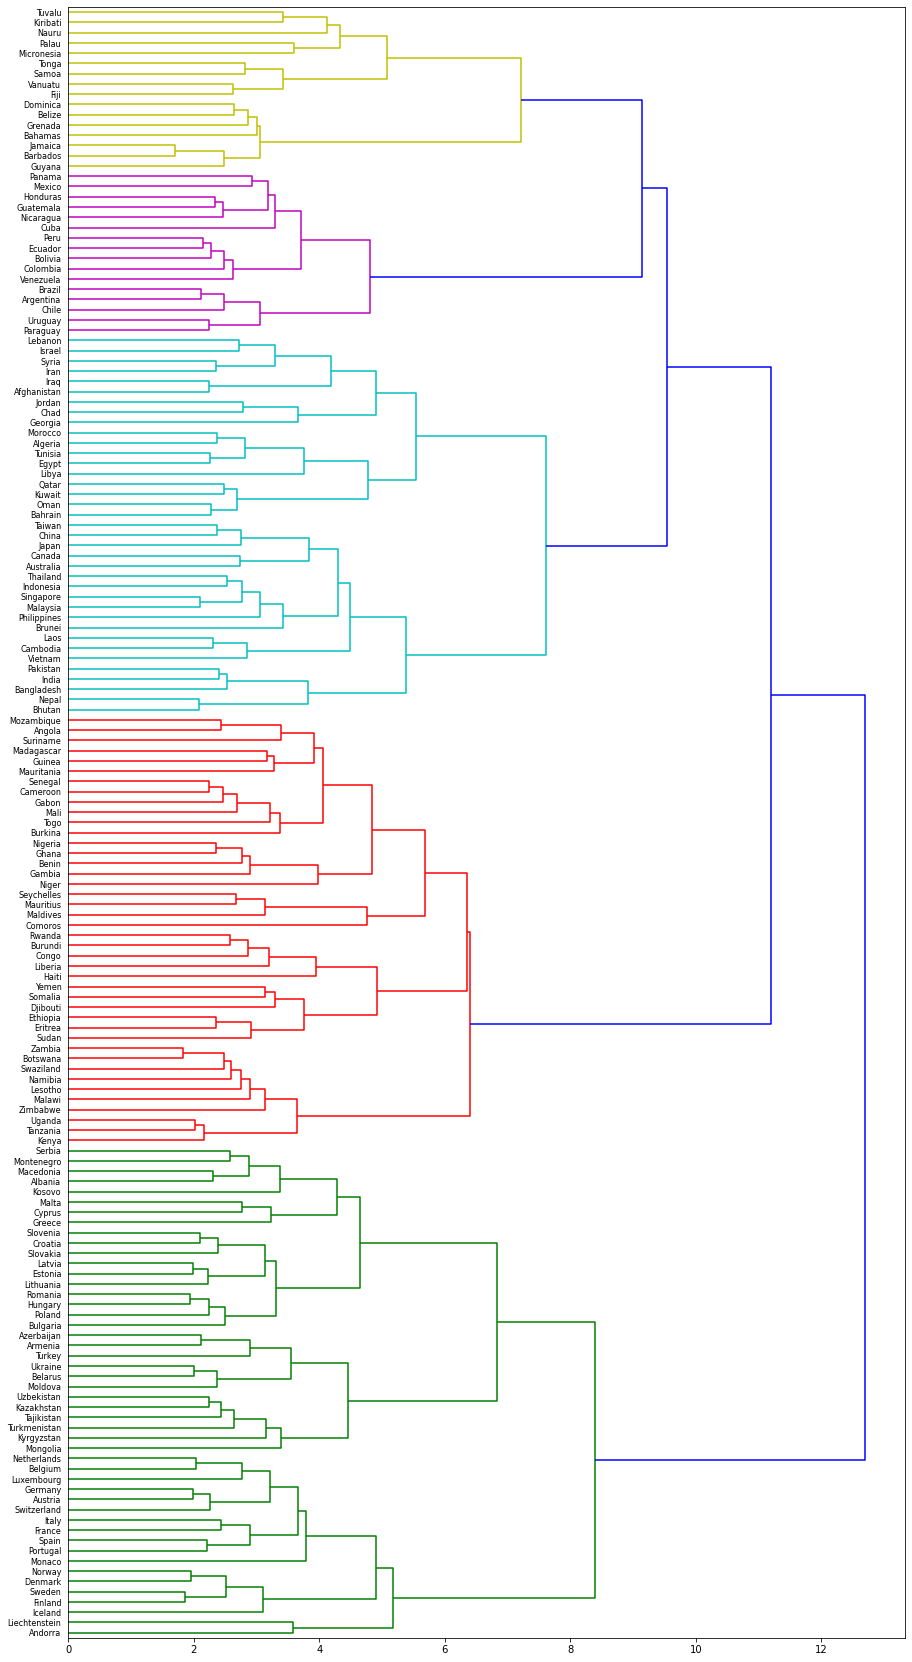

In [14]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline

# vectors, names = load_country_vectors_and_names()

cluster = linkage(vectors, method='ward')

plt.figure(figsize=(15, 30))
dendrogram(cluster, labels=names, leaf_font_size=8, orientation='right')
plt.show()

# 69. t-SNEによる可視化
ベクトル空間上の国名に関する単語ベクトルをt-SNEで可視化せよ．

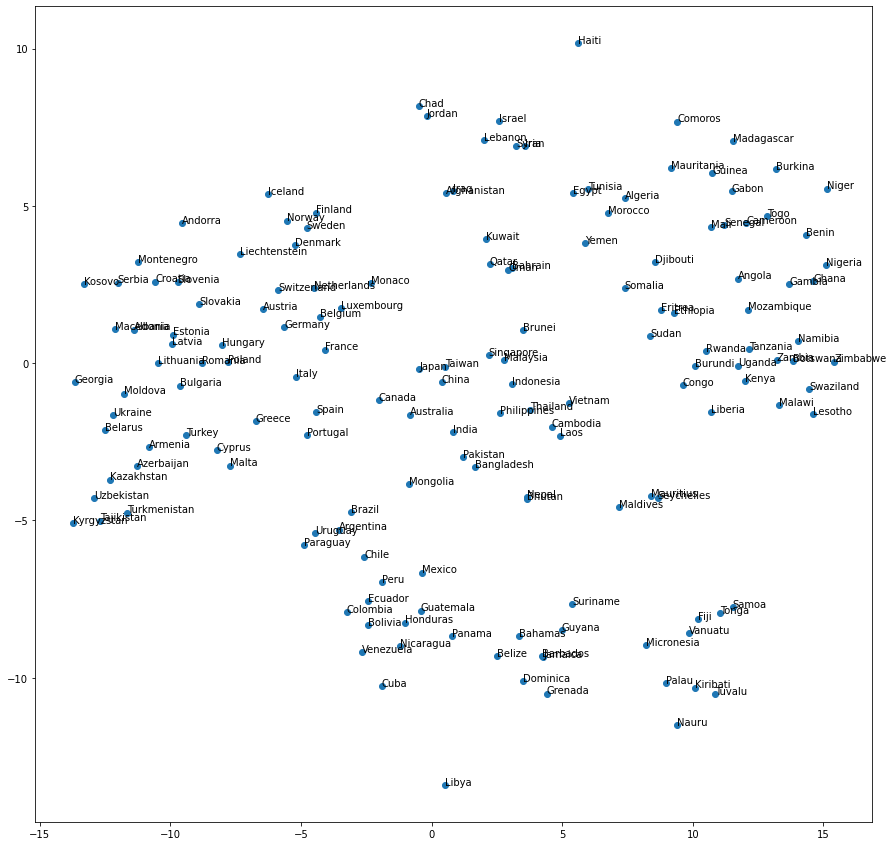

In [15]:
from sklearn.manifold import TSNE

# vectors, names = load_country_vectors_and_names()

tsne = TSNE(n_components=2)
t_sne = tsne.fit_transform(vectors)

plt.figure(figsize=(15, 15))
plt.scatter(t_sne.T[0], t_sne.T[1])
for name, x, y in zip(names, t_sne.T[0], t_sne.T[1]):
    plt.annotate(name, (x, y))
plt.show()